In [1]:
!pip3 install matplotlib

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset
raw_data = pd.read_csv('winequality-white.csv', sep='\t', header=None)  # Using tab as separator

# Split the first column (which contains all attributes) by semicolons
df_split = raw_data[0].str.split(';', expand=True)

# Extract the header from the first row and create a list of attribute names
attribute_names = df_split.iloc[0].str.replace('"', '', regex=False).str.strip()

# Create a DataFrame from the remaining rows (excluding the first one)
df = df_split[1:]

# Assign the header to the DataFrame
df.columns = attribute_names

# Convert only the numeric rows to float, using `pd.to_numeric` to handle conversion
df = df.apply(pd.to_numeric, errors='coerce')
# Check the resulting DataFrame
print("Split DataFrame shape:", df.shape)

Split DataFrame shape: (4898, 12)


In [6]:
# Assuming the last column is the target variable
# X is the features, Y is the target
X = df.iloc[:,:-1]   # All columns except the last one
Y = df.iloc[:, -1]   # The last column is the target
#print(Y)
# Check the split data
print("Feature Matrix (X) shape:", X.shape)
print("Target Vector (Y) shape:", Y.shape)

# Define your percentages
train = 0.7  # 70% for training
# validation = 0.15 # 15% for validation
# The remaining percentage for testing will be (100 - t - v)% = 15%

# Proceed with splitting the dataset
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size = (1-train), random_state = 1)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state= 1)

Feature Matrix (X) shape: (4898, 11)
Target Vector (Y) shape: (4898,)


In [7]:
# Finding the best alpha for L2 and L1 regularization 
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

# Fine best alpha for L2 and L1 regularization
def find_best_alpha(X_train, Y_train, X_valid, Y_valid, reg_type):
    """
    Find the best alpha for L2 regularization using Ridge regression.
    
    Parameters:
    X_train (array-like): Training feature set.
    Y_train (array-like): Training target set.
    X_valid (array-like): Validation feature set.
    Y_valid (array-like): Validation target set.
    alphas (list): List of candidate alpha values for regularization.
    reg_type (str): Type of regularization ('l1' for Lasso, 'l2' for Ridge).
    
    Returns:
    float: The best alpha value with the lowest validation error.
    """
    # Define a list of candidate regularization parameters (alpha values)
    alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    
    validation_errors = []
    for alpha in alphas:
        if reg_type == 'l2':
            # Create the Ridge model with current regularization parameter
            model = Ridge(alpha=alpha)
        elif reg_type == 'l1':
            # Create the Lasso model with current regularization parameter
            model = Lasso(alpha=alpha)
        else:
            raise ValueError("reg_type must be 'l1' or 'l2'.")
            
        # Train the model on the training set
        model.fit(X_train, Y_train)
        
        # Predict on the validation set
        Y_valid_hat = model.predict(X_valid)
        
        # Compute the validation error (MSE in this case)
        mse = mean_squared_error(Y_valid, Y_valid_hat)
        validation_errors.append(mse)

    # Find the best alpha (with the lowest validation error)
    best_alpha = alphas[np.argmin(validation_errors)]
    return best_alpha

In [8]:
# Batch Gradient Descent without Regularization, with L1 and L2 Regularization
def batch_gradient_descent(X_train, Y_train, X_valid, Y_valid, learning_rate, epochs, reg_type='none'):
    m, n = X_train.shape
    W = np.zeros(n + 1) # Weight vector initializatio- we started with a zero vector
    X_train = np.c_[np.ones((m, 1)), X_train] # Add bias term for train set
    X_valid = np.c_[np.ones((X_valid.shape[0], 1)), X_valid]  # Add bias term for valid set

    best_alpha = None
    if reg_type in ['l1', 'l2']:
        best_alpha = find_best_alpha(X_train, Y_train, X_valid, Y_valid, reg_type)
        print(f"Best regularization parameter (alpha) for {reg_type}: {best_alpha}")

    for epoch in range (epochs):
        Y_hat = np.dot(X_train,W) # Compute predictions
        mse = np.mean((Y_train - Y_hat) ** 2) # Mean Squared Error

        if reg_type == 'l2':
            gradient = (2/m) * np.dot(X_train.T, (Y_hat - Y_train)) + 2*best_alpha*W # Gradient
        elif reg_type == 'l1':
            gradient = (2/m) * np.dot(X_train.T, (Y_hat - Y_train)) + best_alpha*np.sign(W) # Gradient
        else:
            gradient = (2/m) * np.dot(X_train.T, (Y_hat - Y_train)) # Gradient
        
        W = W-learning_rate * gradient  # Update weights

        if epoch % 10 == 0:
            print(f'Epoch {epoch}: MSE = {mse}')
            
    return W, Y_hat, mse

In [9]:
# Batch without Regularization
W_batch, Y_hat, mse = batch_gradient_descent(X_train, Y_train, X_valid, Y_valid, learning_rate=0.00001, epochs=8000, reg_type='none')
print("Weights from Batch GD without Regularization:", np.round(W_batch,5))
#We tried 100,000 interations and found that after almost 8000 iterations, MSE was almost stagnant around 0.67. 

Epoch 0: MSE = 35.236289381563594
Epoch 10: MSE = 4.1802724463143885
Epoch 20: MSE = 4.1537305161725575
Epoch 30: MSE = 4.1275762153136215
Epoch 40: MSE = 4.101619657734249
Epoch 50: MSE = 4.075859330524654
Epoch 60: MSE = 4.050293733852131
Epoch 70: MSE = 4.024921379704523
Epoch 80: MSE = 3.9997407917793746
Epoch 90: MSE = 3.9747505053752183
Epoch 100: MSE = 3.949949067284896
Epoch 110: MSE = 3.925335035690818
Epoch 120: MSE = 3.9009069800620764
Epoch 130: MSE = 3.8766634810533214
Epoch 140: MSE = 3.8526031304053276
Epoch 150: MSE = 3.828724530847181
Epoch 160: MSE = 3.80502629600001
Epoch 170: MSE = 3.7815070502822015
Epoch 180: MSE = 3.758165428816046
Epoch 190: MSE = 3.7350000773357435
Epoch 200: MSE = 3.712009652096727
Epoch 210: MSE = 3.6891928197862573
Epoch 220: MSE = 3.666548257435222
Epoch 230: MSE = 3.6440746523311227
Epoch 240: MSE = 3.6217707019321876
Epoch 250: MSE = 3.599635113782578
Epoch 260: MSE = 3.577666605428658
Epoch 270: MSE = 3.55586390433628
Epoch 280: MSE = 3.

In [10]:
# Batch L2 Regularization
#W_batch_l2 = batch_gradient_descent_l2(X_train, Y_train, learning_rate=0.00001, epochs=10000)
W_batch_l2, Y_hat_l2, mse_l2 = batch_gradient_descent(X_train, Y_train, X_valid, Y_valid, learning_rate=0.00001, epochs=10000, reg_type='l2')
print("Weights from Batch GD with L2 Regularization:", np.round(W_batch_l2,5))
# We tried 100,000 interations and found that after almost 10000 iterations, value of the cost function was almost stagnant around 0.68#Define learning rate

Best regularization parameter (alpha) for l2: 0.0001
Epoch 0: MSE = 35.236289381563594
Epoch 10: MSE = 4.180272447214731
Epoch 20: MSE = 4.153730517174711
Epoch 30: MSE = 4.127576217589772
Epoch 40: MSE = 4.101619661789895
Epoch 50: MSE = 4.075859336853967
Epoch 60: MSE = 4.0502937429397345
Epoch 70: MSE = 4.02492139202562
Epoch 80: MSE = 3.9997408077998724
Epoch 90: MSE = 3.9747505255518507
Epoch 100: MSE = 3.9499490920653413
Epoch 110: MSE = 3.925335065513823
Epoch 120: MSE = 3.900907015357569
Epoch 130: MSE = 3.876663522242531
Epoch 140: MSE = 3.8526031779008996
Epoch 150: MSE = 3.828724585053289
Epoch 160: MSE = 3.80502635731247
Epoch 170: MSE = 3.7815071190885847
Epoch 180: MSE = 3.7581655054957848
Epoch 190: MSE = 3.7350001622602433
Epoch 200: MSE = 3.712009745629476
Epoch 210: MSE = 3.6891929222829276
Epoch 220: MSE = 3.6665483692437775
Epoch 230: MSE = 3.6440747737919237
Epoch 240: MSE = 3.6217708333780925
Epoch 250: MSE = 3.599635255539048
Epoch 260: MSE = 3.5776667578138523
E

In [11]:
# Batch L1 Regularization
#W_batch_l1 = batch_gradient_descent_l1(X_train, Y_train, learning_rate=0.00001, epochs=11000)
W_batch_l1, Y_hat_l1, mse_l1 = batch_gradient_descent(X_train, Y_train, X_valid, Y_valid, learning_rate=0.00001, epochs=11000, reg_type='l1')
print("Weights from Batch GD with L1 Regularization:", np.round(W_batch_l1,5))
# We tried 100,000 interations and found that after almost 11000 iterations, value of the cost function was almost stagnant around 0.68

Best regularization parameter (alpha) for l1: 0.001
Epoch 0: MSE = 35.236289381563594
Epoch 10: MSE = 4.18027490878539
Epoch 20: MSE = 4.153735417887972
Epoch 30: MSE = 4.127583655370923
Epoch 40: MSE = 4.101629608533638
Epoch 50: MSE = 4.075871764430248
Epoch 60: MSE = 4.050308623500023
Epoch 70: MSE = 4.024938697998376
Epoch 80: MSE = 3.999760511885496
Epoch 90: MSE = 3.974772600717866
Epoch 100: MSE = 3.949973511541812
Epoch 110: MSE = 3.925361802788966
Epoch 120: MSE = 3.900936044173568
Epoch 130: MSE = 3.87669481659153
Epoch 140: MSE = 3.852636712021167
Epoch 150: MSE = 3.8287603334255444
Epoch 160: MSE = 3.8050642946563578
Epoch 170: MSE = 3.781547220359287
Epoch 180: MSE = 3.7582077458807714
Epoch 190: MSE = 3.73504451717614
Epoch 200: MSE = 3.712056190719048
Epoch 210: MSE = 3.6892414334121746
Epoch 220: MSE = 3.6665989224991327
Epoch 230: MSE = 3.644127345477543
Epoch 240: MSE = 3.6218254000132335
Epoch 250: MSE = 3.59969179385554
Epoch 260: MSE = 3.57772524475364
Epoch 270: M

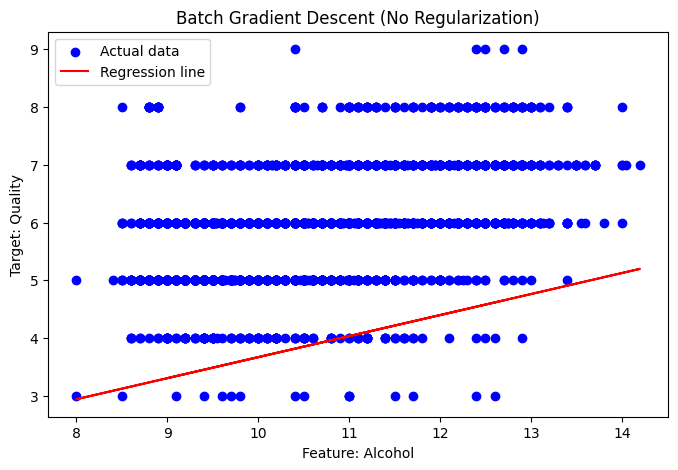

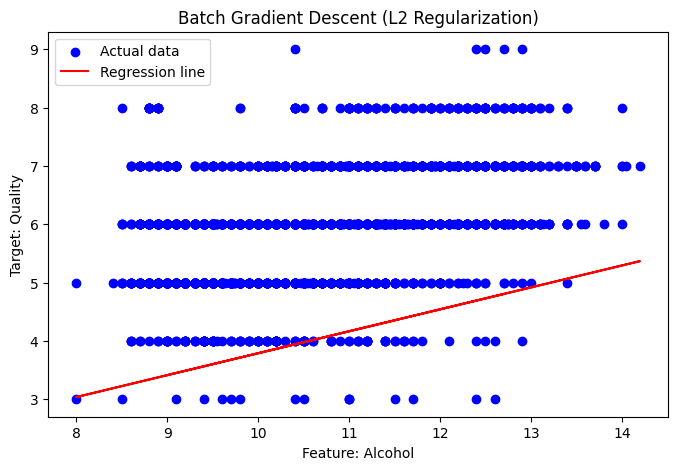

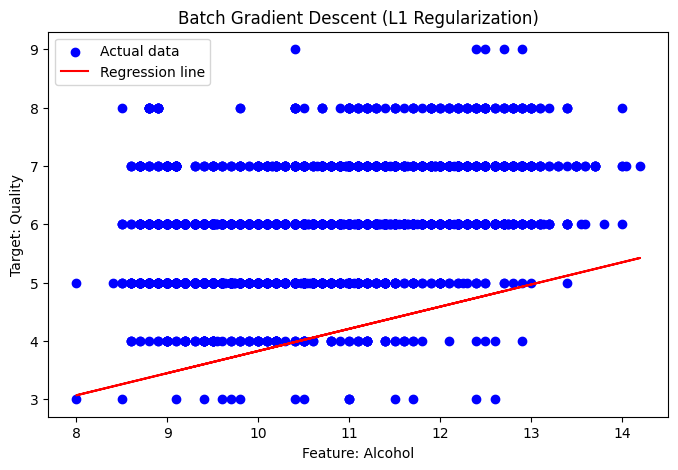

In [12]:
# Plot the regression lines
import matplotlib.pyplot as plt

def plot_regression_line(X, y, w, attribute_idx, title):
    plt.figure(figsize=(8,5))

   # Use .iloc for index-based access to the DataFrame
    plt.scatter(X.iloc[:, attribute_idx], y, color='blue', label='Actual data')

    # Calculate predicted values
    y_pred = X.iloc[:, attribute_idx] * w[attribute_idx] + w[0]  # w[0] is the bias (intercept)

    plt.plot(X.iloc[:, attribute_idx], y_pred, color='red', label='Regression line')

    plt.title(title)
    column_name= X.columns[attribute_idx]
    plt.xlabel(f'Feature: {str.capitalize(column_name)}')

    plt.ylabel('Target: Quality')

    plt.legend()

    plt.show()

# Redefine X
m, n = X_train.shape
X_train_with_bias = np.c_[np.ones((m, 1)), X_train] # Add bias term
# Use pandas to create a DataFrame with the bias term
X_train_with_bias_df = pd.DataFrame(X_train_with_bias, columns=['Bias'] + X_train.columns.tolist())


# Batch Gradient Descent (No Regularization)
max_weight_idx = np.argmax(np.abs(W_batch[1:])) + 1  # Skip the bias term
plot_regression_line(X_train_with_bias_df, Y_train, W_batch, max_weight_idx, 'Batch Gradient Descent (No Regularization)')

# Batch Gradient Descent (L2 Regularization)
max_weight_idx_l2 = np.argmax(np.abs(W_batch_l2[1:])) + 1  # Skip the bias term
plot_regression_line(X_train_with_bias_df, Y_train, W_batch_l2, max_weight_idx_l2, 'Batch Gradient Descent (L2 Regularization)')

# Batch Gradient Descent (L1 Regularization)
max_weight_idx_l1 = np.argmax(np.abs(W_batch_l1[1:])) + 1  # Skip the bias term
plot_regression_line(X_train_with_bias_df, Y_train, W_batch_l1, max_weight_idx_l1, 'Batch Gradient Descent (L1 Regularization)')

# Mini_Batch Gradient Descent (No Regularization)
max_weight_idx_mini = np.argmax(np.abs(W_mini_batch[1:])) + 1  # Skip the bias term
plot_regression_line(X_train_with_bias_df, Y_train, W_mini_batch, max_weight_idx_mini, 'Mini Batch Gradient Descent (No Regularization)')

# Mini_Batch Gradient Descent (L2 Regularization)
max_weight_idx_l2_mini = np.argmax(np.abs(W_mini_batch_l2[1:])) + 1  # Skip the bias term
plot_regression_line(X_train_with_bias_df, Y_train, W_mini_batch_l2, max_weight_idx_l2_mini, 'Mini Batch Gradient Descent (L2 Regularization)')

# Mini_Batch Gradient Descent (L1 Regularization)
max_weight_idx_l1_mini = np.argmax(np.abs(W_mini_batch_l1[1:])) + 1  # Skip the bias term
plot_regression_line(X_train_with_bias_df, Y_train, W_mini_batch_l1, max_weight_idx_l1_mini, 'Mini Batch Gradient Descent (L1 Regularization)')


In [16]:
# Mini-Batch Gradient Descent without Regularization, L1 and L2 Regularization
def mini_batch_gradient_descent(X_train, Y_train, X_valid, Y_valid, learning_rate, epochs, batch_size, reg_type='none'):
    m, n = X_train.shape
    W = np.zeros(n + 1)  #  Weight vector initializatio- we started with a zero vector
    X_train = np.c_[np.ones((m, 1)), X_train] # Add bias term for train set
    X_valid = np.c_[np.ones((X_valid.shape[0], 1)), X_valid]  # Add bias term for valid set

    best_aplha = None
    if reg_type in ['l1', 'l2']:
        best_alpha = find_best_alpha(X_train, Y_train, X_valid, Y_valid, reg_type)
        print(f"Best regularization parameter (alpha) for {reg_type}: {best_alpha}")

    for epoch in range(epochs):        
        # Initialize epoch-level MSE accumulator
        epoch_mse_sum = 0

        # Iterate over mini-batches
        for i in range(0, m, batch_size):
            # Select mini-batches stochastically by random sampling of indices
            random_indices = np.random.choice(m, batch_size, replace=False)
            X_batch = X_train[random_indices]
            Y_batch = Y_train.iloc[random_indices]
            #print('After splitt-i---------', X_batch.shape, Y_batch.shape)
            
            Y_hat = np.dot(X_batch, W) # Compute predictions for the given batch
            mse = np.mean((Y_batch - Y_hat) ** 2) # computing mean squared error
            epoch_mse_sum += mse

            if reg_type == 'l2':
                gradient = (2/batch_size) * np.dot(X_batch.T, (Y_hat - Y_batch)) + 2*best_alpha*W # Gradient
            elif reg_type == 'l1': 
                gradient = (2/batch_size) * np.dot(X_batch.T, (Y_hat - Y_batch)) + best_alpha*np.sign(W) # Gradient
            else:
                gradient = (2 / batch_size) * np.dot(X_batch.T, (Y_hat - Y_batch))  # Gradient
            
            W = W - learning_rate * gradient # updation of weights for this batch
        
        epoch_mse = epoch_mse_sum / (m // batch_size)       # Average MSE over the entire epoch
        
        # Print the MSE every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: MSE = {epoch_mse}')
    
    return W, Y_hat, mse


In [14]:
#Mini_Batch without Regularization
W_mini_batch, Y_hat_mini, mse_mini = mini_batch_gradient_descent(X_train, Y_train, X_valid, Y_valid, learning_rate=0.00001, epochs=8000, batch_size=32, reg_type='none')
print("Weights from Mini-Batch GD without Regularization:",np.round(W_mini_batch,5))

Epoch 0: MSE = 4.56664004324351
Epoch 10: MSE = 2.35264690669852
Epoch 20: MSE = 1.3847291030257374
Epoch 30: MSE = 0.9071251865533508
Epoch 40: MSE = 0.8640189084714867
Epoch 50: MSE = 0.7400089236136406
Epoch 60: MSE = 0.7176387090876157
Epoch 70: MSE = 0.6896151945255109
Epoch 80: MSE = 0.6655006276721047
Epoch 90: MSE = 0.6672128464021465
Epoch 100: MSE = 0.710167038249831
Epoch 110: MSE = 0.6907874746479306
Epoch 120: MSE = 0.6544473220433085
Epoch 130: MSE = 0.6489243130526449
Epoch 140: MSE = 0.6994641284267767
Epoch 150: MSE = 0.6914101325466202
Epoch 160: MSE = 0.6539067396951838
Epoch 170: MSE = 0.6964598594536454
Epoch 180: MSE = 0.6760136031735227
Epoch 190: MSE = 0.7064463056040055
Epoch 200: MSE = 0.6693470551105296
Epoch 210: MSE = 0.6983680164571854
Epoch 220: MSE = 0.6773157933537275
Epoch 230: MSE = 0.6816717868506045
Epoch 240: MSE = 0.6841345245519463
Epoch 250: MSE = 0.6511117328064957
Epoch 260: MSE = 0.63826467048975
Epoch 270: MSE = 0.6487020842553953
Epoch 280:

In [19]:
#Mini_Batch L2 Regularization
W_mini_batch_l2, Y_hat_mini_l2, mse_mini_l2 = mini_batch_gradient_descent(X_train, Y_train, X_valid, Y_valid, learning_rate=0.00001, epochs=12000, batch_size=32, reg_type='l2')
print("Weights from Mini-Batch GD without Regularization:", np.round(W_mini_batch_l2,5))

Best regularization parameter (alpha) for l2: 0.0001
Epoch 0: MSE = 4.446026485819454
Epoch 10: MSE = 2.2011025244696616
Epoch 20: MSE = 1.3685972801074673
Epoch 30: MSE = 1.042440662665936
Epoch 40: MSE = 0.8269160906992469
Epoch 50: MSE = 0.7508637083491206
Epoch 60: MSE = 0.7215416736864968
Epoch 70: MSE = 0.6912262450265353
Epoch 80: MSE = 0.6910033798191928
Epoch 90: MSE = 0.6952076314387213
Epoch 100: MSE = 0.6966314672912108
Epoch 110: MSE = 0.7004447579061763
Epoch 120: MSE = 0.7016997898997148
Epoch 130: MSE = 0.6597568717482797
Epoch 140: MSE = 0.648196362828546
Epoch 150: MSE = 0.7025141488928109
Epoch 160: MSE = 0.6533765083573797
Epoch 170: MSE = 0.6572534824034333
Epoch 180: MSE = 0.6521098619538167
Epoch 190: MSE = 0.678838663648706
Epoch 200: MSE = 0.6559389238479502
Epoch 210: MSE = 0.6605347245713106
Epoch 220: MSE = 0.6750490306209533
Epoch 230: MSE = 0.6430140379357938
Epoch 240: MSE = 0.6610576632925124
Epoch 250: MSE = 0.691261344490061
Epoch 260: MSE = 0.70379040

In [20]:
#Mini_Batch L1 Regularization
W_mini_batch_l1, Y_hat_mini_l1, mse_mini_l1 = mini_batch_gradient_descent(X_train, Y_train, X_valid, Y_valid, learning_rate=0.00001, epochs=11000, batch_size=32, reg_type='l1')
print("Weights from Mini-Batch GD without Regularization:", np.round(W_mini_batch_l1,5))

Best regularization parameter (alpha) for l1: 0.001
Epoch 0: MSE = 4.579664957623738
Epoch 10: MSE = 2.1691335391204896
Epoch 20: MSE = 1.3560821881583094
Epoch 30: MSE = 0.9944770365360014
Epoch 40: MSE = 0.8039621832356642
Epoch 50: MSE = 0.7530369504771284
Epoch 60: MSE = 0.7124475768787408
Epoch 70: MSE = 0.669789865749216
Epoch 80: MSE = 0.7040963861544267
Epoch 90: MSE = 0.7080931293164342
Epoch 100: MSE = 0.6722563467146362
Epoch 110: MSE = 0.6915080473788526
Epoch 120: MSE = 0.6610171980064689
Epoch 130: MSE = 0.6577765731226028
Epoch 140: MSE = 0.6980136178220498
Epoch 150: MSE = 0.6745330822641399
Epoch 160: MSE = 0.6616072837580986
Epoch 170: MSE = 0.6230350430902039
Epoch 180: MSE = 0.6625965440412543
Epoch 190: MSE = 0.6535396087200926
Epoch 200: MSE = 0.675660205133451
Epoch 210: MSE = 0.6688046772828784
Epoch 220: MSE = 0.6725549998221229
Epoch 230: MSE = 0.6785651374154654
Epoch 240: MSE = 0.6532581551985178
Epoch 250: MSE = 0.6733892684124757
Epoch 260: MSE = 0.6841607

In [22]:
#Finding the smallest component of the weight vector after training with batch gradient descent using L2 Regularization
min_weight_idx_batch_l2 = np.argmin(np.abs(W_batch_l2[1:])) + 1  # Skip the bias term
print(min_weight_idx_batch_l2, np.round(W_batch_l2[min_weight_idx_batch_l2],5))


#Removing least contributed column in both X_train, X_valid
X_train_reduced = np.delete(X_train, min_weight_idx_batch_l2 - 1, axis=1)  # Removing column from X_train (subtract 1 to match 0-indexing)
X_valid_reduced = np.delete(X_valid, min_weight_idx_batch_l2 - 1, axis=1)  # Removing column from X_valid

print(f"X_train shape after removing feature: {X_train_reduced.shape}")
print(f"X_valid shape after removing feature: {X_valid_reduced.shape}")

#Training again using reduced weights using batch gradient descent with L2 regularixation
W_batch_l2_reduced, Y_hat_l2_reduced, mse_l2_reduced = batch_gradient_descent(X_train_reduced, Y_train, X_valid_reduced, Y_valid, learning_rate=0.00001, epochs=10000, reg_type='l2')
print("Weights from Batch GD with L2 Regularization after reducing attributes:", np.round(W_batch_l2_reduced,5))


5 0.00097
X_train shape after removing feature: (3428, 10)
X_valid shape after removing feature: (735, 10)
Best regularization parameter (alpha) for l2: 0.0001
Epoch 0: MSE = 35.236289381563594
Epoch 10: MSE = 4.180272849456339
Epoch 20: MSE = 4.15373099891915
Epoch 30: MSE = 4.127576777854722
Epoch 40: MSE = 4.101620299333442
Epoch 50: MSE = 4.0758600504482425
Epoch 60: MSE = 4.050294531370787
Epoch 70: MSE = 4.02492225409329
Epoch 80: MSE = 3.999741742317663
Epoch 90: MSE = 3.9747515313467985
Epoch 100: MSE = 3.949950167977895
Epoch 110: MSE = 3.9253362103977105
Epoch 120: MSE = 3.9009082280796785
Epoch 130: MSE = 3.8766648016827787
Epoch 140: MSE = 3.852604522952112
Epoch 150: MSE = 3.8287259946210734
Epoch 160: MSE = 3.8050278303150935
Epoch 170: MSE = 3.781508654456851
Epoch 180: MSE = 3.7581671021729144
Epoch 190: MSE = 3.7350018192017505
Epoch 200: MSE = 3.7120114618030464
Epoch 210: MSE = 3.6891946966683014
Epoch 220: MSE = 3.6665502008326314
Epoch 230: MSE = 3.644076661587751


In [ ]:
#Finding the smallest component of the weight vector after training with batch gradient descent using L1 Regularization
min_weight_idx_batch_l1 = np.argmin(np.abs(W_batch_l1[1:])) + 1  # Skip the bias term
print(min_weight_idx_batch_l1, np.round(W_batch_l1[min_weight_idx_batch_l1],5))


#Removing least contributed column in both X_train, X_valid
X_train_reduced = np.delete(X_train, min_weight_idx_batch_l1 - 1, axis=1)  # Removing column from X_train (subtract 1 to match 0-indexing)
X_valid_reduced = np.delete(X_valid, min_weight_idx_batch_l1 - 1, axis=1)  # Removing column from X_valid

print(f"X_train shape after removing feature: {X_train_reduced.shape}")
print(f"X_valid shape after removing feature: {X_valid_reduced.shape}")

#Training again using reduced weights using batch gradient descent with L2 regularixation
W_batch_l1_reduced, Y_hat_l1_reduced, mse_l1_reduced = batch_gradient_descent(X_train_reduced, Y_train, X_valid_reduced, Y_valid, learning_rate=0.00001, epochs=11000, reg_type='l1')
print("Weights from Batch GD with L1 Regularization after reducing attributes:", np.round(W_batch_l1_reduced,5))
